In [1]:
#Import required libraries/packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding

Using TensorFlow backend.


__1. Preparing the Data__

In [2]:
features = list()
with open("Data/features.txt") as f:
    for line in f:
        features.append(line)

In [3]:
#Prepare Dataframe with features, subject ID and activity labels
def prepare_df(path,df_type):
    df = pd.read_csv(path+"/X_"+df_type+".txt", delim_whitespace = True, names = features)
    df["Subject_Id"]= pd.read_csv(path+"/subject_"+df_type+".txt", header=None)

    activity=pd.read_csv(path+"/y_"+df_type+".txt", header=None, squeeze=True)
    df["Activity"] = activity

    activity_name = activity.map({1: "WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4:"SITTING", 5:"STANDING", 6:"LYING"})
    df["Label"] = activity_name
    
    df=df.dropna()
    return df  

In [4]:
#Training Dataframe
train_path = "Data/train"
train_df = prepare_df(train_path,"train")

#Testing Dataframe
test_path = "Data/test"
test_df = prepare_df(test_path,"test")

train_df.head()

,1 tBodyAcc-mean()-X,2 tBodyAcc-mean()-Y,3 tBodyAcc-mean()-Z,4 tBodyAcc-std()-X,5 tBodyAcc-std()-Y,6 tBodyAcc-std()-Z,7 tBodyAcc-mad()-X,8 tBodyAcc-mad()-Y,9 tBodyAcc-mad()-Z,10 tBodyAcc-max()-X,...,"555 angle(tBodyAccMean,gravity)","556 angle(tBodyAccJerkMean),gravityMean)","557 angle(tBodyGyroMean,gravityMean)","558 angle(tBodyGyroJerkMean,gravityMean)","559 angle(X,gravityMean)","560 angle(Y,gravityMean)","561 angle(Z,gravityMean)",Subject_Id,Activity,Label
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,5,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,5,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,5,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,5,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,5,STANDING


In [5]:
accuracy_record = pd.DataFrame(columns = ["Model", "Accuracy"])

In [6]:
def eval_metric(model,test_y, y_pred):
    global accuracy_record
    
    accuracy = accuracy_score(test_y, y_pred)
    accuracy_record= accuracy_record.append(pd.DataFrame([[model, accuracy]], columns = ["Model", "Accuracy"]))
       
    print(classification_report(test_y, y_pred))
    print("\nAccuracy:", accuracy)
    print("\nConfusion Matrix:")
    labels = ["Walking", "Walking_Upstairs", "Walking_Downstairs", "Sitting", "Standing", "Laying"]
    confusion = confusion_matrix(test_y, y_pred)
    sb.heatmap(confusion, cmap = "Blues", annot=True, fmt = '.2f', xticklabels = labels, yticklabels = labels)
        
    return accuracy

__2. Benchmark Model__

In [7]:
#Split the dataframe into x and y dataframes 

train_x= train_df.iloc[:,0:560]
train_y= train_df["Activity"]
test_x= test_df.iloc[:,0:560]
test_y= test_df["Activity"] 

              precision    recall  f1-score   support

           1       0.84      0.92      0.88       496
           2       0.84      0.77      0.80       471
           3       0.85      0.83      0.84       420
           4       0.83      0.78      0.80       491
           5       0.81      0.85      0.83       532
           6       1.00      1.00      1.00       537

    accuracy                           0.86      2947
   macro avg       0.86      0.86      0.86      2947
weighted avg       0.86      0.86      0.86      2947


Accuracy: 0.8625721072276892

Confusion Matrix:


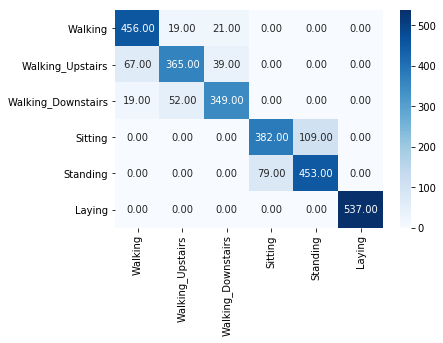

In [8]:
#Decision Trees Classifier

model = "Decision Tree Classifier"
benchmark = DecisionTreeClassifier()  #Initialize the model
benchmark.fit(train_x, train_y)  #Fit the model to input data with 561 features

y_pred= benchmark.predict(test_x)  #Predict activity labels 

#Calculate evaluation metrics
accuracy = eval_metric(model,test_y, y_pred)


__3. Feature Selection__

In [9]:
n_features=125 #picking number of features based on feature importance score>0

#Extracting features based on impact on model
feat_importances = pd.Series(benchmark.feature_importances_, index=train_x.columns)
features = feat_importances.nlargest(n_features)
print(features.head(20))

feature_list= features.index.values.tolist()

train_feat_x = train_x[feature_list]
train_selected_df = pd.concat([train_feat_x, train_y], axis=1)

test_feat_x = test_x[feature_list]

53 tGravityAcc-min()-X\n                 0.240265
394 fBodyAccJerk-bandsEnergy()-1,24\n    0.202710
560 angle(Y,gravityMean)\n               0.132955
509 fBodyAccMag-energy()\n               0.109366
75 tGravityAcc-arCoeff()-Z,2\n           0.096493
449 fBodyGyro-maxInds-X\n                0.022702
160 tBodyGyro-correlation()-Y,Z\n        0.015639
58 tGravityAcc-energy()-Y\n              0.015564
210 tBodyAccMag-arCoeff()1\n             0.014908
130 tBodyGyro-max()-X\n                  0.008665
276 fBodyAcc-max()-Y\n                   0.008357
54 tGravityAcc-min()-Y\n                 0.007554
38 tBodyAcc-correlation()-X,Y\n          0.007002
51 tGravityAcc-max()-Y\n                 0.005957
133 tBodyGyro-min()-X\n                  0.005184
433 fBodyGyro-max()-X\n                  0.004969
118 tBodyAccJerk-correlation()-X,Y\n     0.003757
170 tBodyGyroJerk-max()-X\n              0.003287
72 tGravityAcc-arCoeff()-Y,3\n           0.002864
52 tGravityAcc-max()-Z\n                 0.002829


__4. Implementing Supervised Learning Models__

              precision    recall  f1-score   support

           1       0.87      0.95      0.91       496
           2       0.86      0.87      0.86       471
           3       0.98      0.86      0.91       420
           4       0.89      0.85      0.87       491
           5       0.87      0.90      0.88       532
           6       1.00      1.00      1.00       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947


Accuracy: 0.9083814048184594

Confusion Matrix:


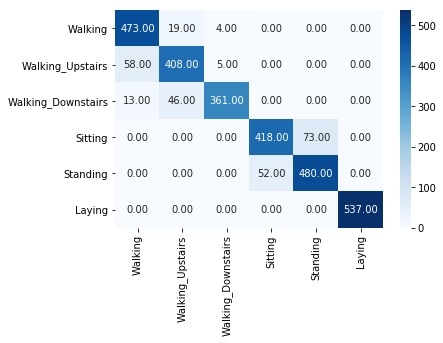

In [10]:
#Random Forest Classifier

model = "Random Forest Classifier"
rf=RandomForestClassifier(n_estimators=100)
rf.fit(train_feat_x, train_y)

y_pred = rf.predict(test_feat_x)

accuracy = eval_metric(model,test_y, y_pred)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           1       0.95      0.99      0.97       496
           2       0.92      0.96      0.94       471
           3       1.00      0.91      0.95       420
           4       0.91      0.84      0.87       491
           5       0.86      0.92      0.89       532
           6       1.00      1.00      1.00       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947


Accuracy: 0.9379029521547336

Confusion Matrix:


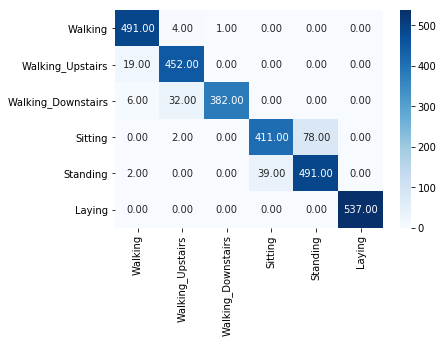

In [11]:
#Linear SV Classifier

model = "Linear SVC"
svc = LinearSVC()
svc.fit(train_feat_x, train_y)

y_pred= svc.predict(test_feat_x)

accuracy = eval_metric(model,test_y, y_pred)

__5. Applying Deep Learning Model__

In [12]:
# Load the input signals

def load_signal(datatype):
    signal_data = []
    signal_list = ["body_acc_x_", "body_acc_y_", "body_acc_z_", "body_gyro_x_", "body_gyro_y_", "body_gyro_z_", 
                   "total_acc_x_", "total_acc_y_", "total_acc_z_"]
    for signal in signal_list:
        file = "Data/"+ datatype +"/Inertial Signals/"+ signal + datatype +".txt"
        read_file = pd.read_csv(file, delim_whitespace = True, header = None)
        signal_data.append((read_file).as_matrix())
        
    return np.transpose(signal_data, (1,2,0))

In [13]:
def load_labels(datatype):
    file = pd.read_csv(("Data/"+datatype+"/y_"+datatype+".txt"), delim_whitespace = True, header = None)
    y = pd.get_dummies(file[0]).as_matrix()
    
    return y

In [14]:
x_train = load_signal("train")
y_train = load_labels("train")
x_test = load_signal("test")
y_test = load_labels("test")

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


In [15]:
#2-layer LSTM model

epochs = 8
batch_size = 32
timesteps = x_train.shape[1]
input_dim = len(x_train[0][0])
n_classes = 6

model = Sequential()

model.add(LSTM(64, return_sequences = True, input_shape = (timesteps, input_dim)))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences = False))
model.add(Dropout(0.5))

model.add(Dense(n_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

result = model.fit(x_train, y_train, batch_size = batch_size, epochs=epochs, verbose=2, validation_split=0.01)

validation_acc = np.amax(result.history['val_acc'])

trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 7278 samples, validate on 74 samples
Epoch 1/8





 - 162s - loss: 1.3612 - acc: 0.4085 - val_loss: 1.5454 - val_acc: 0.3514
Epoch 2/8
 - 157s - loss: 1.2915 - acc: 0.4261 - val_loss: 1.4233 - val_acc: 0.4054
Epoch 3/8
 - 156s - loss: 1.1922 - acc: 0.4724 - val_loss: 1.4530 - val_acc: 0.4459
Epoch 4/8
 - 156s - loss: 1.1180 - acc: 0.5106 - val_loss: 1.8202 - val_acc: 0.1351
Epoch 5/8
 - 154s - loss: 1.0080 - acc: 0.5624 - val_loss: 1.1625 - val_acc: 0.4054
Epoch 6/8
 - 156s - loss: 0.7840 - acc: 0.6195 - val_loss: 1.1243 - val_acc: 0.4054
Epoch 7/8
 - 156s - loss: 0.7565 - acc: 0.6219 - val_loss: 1.1093 - val_acc: 0.4054
Epoch 8/8
 - 156s - loss: 0.7142 - acc: 0.6407 - val_loss: 1.1114 - val_acc: 0.2162


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

              precision    recall  f1-score   support

           1       0.34      0.98      0.51       496
           2       0.00      0.00      0.00       471
           3       0.00      0.00      0.00       420
           4       0.79      0.73      0.76       491
           5       0.75      0.80      0.78       532
           6       1.00      0.94      0.97       537

    accuracy                           0.60      2947
   macro avg       0.48      0.58      0.50      2947
weighted avg       0.51      0.60      0.53      2947


Accuracy: 0.6040040719375637

Confusion Matrix:


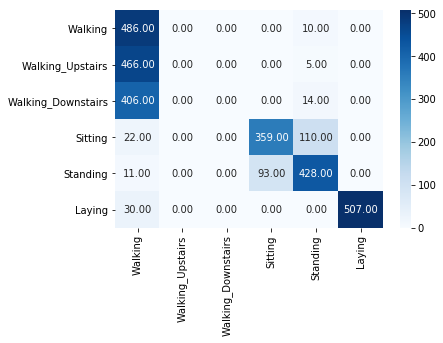

In [16]:
model = "LSTM"
true_labels = [np.argmax(i)+1 for i in y_test]
predicted_labels = [np.argmax(i)+1 for i in testPredict]
accuracy=eval_metric(model,true_labels, predicted_labels)

In [17]:
accuracy_record.reset_index(drop=True, inplace=True)
print(accuracy_record)

                      Model  Accuracy
0  Decision Tree Classifier  0.862572
1  Random Forest Classifier  0.908381
2                Linear SVC  0.937903
3                      LSTM  0.604004
